In [ ]:
import sys

import uproot4 as uproot
import numpy as np
import awkward1 as ak

import gc

import torch
import torch.nn as nn

from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import time

#from ROOT import *

ModuleNotFoundError: No module named 'torch'

In [1]:
import sys

import uproot as uproot
import numpy as np
import awkward as ak

import gc

#import torch
#import torch.nn as nn

#from sklearn import metrics
#from sklearn.utils.class_weight import compute_class_weight
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler

#import time

#from ROOT import *

In [4]:
import pandas as pd

In [3]:
def cleandataset(f, defaults):
    # the feature-names are the attributes or columns of interest, in this case: information about Jets
    feature_names = [k for k in f['Events'].keys() if  (('Jet_eta' == k) or ('Jet_pt' == k) or ('Jet_DeepCSV' in k))]
    # tagger output to compare with later and variables used to get the truth output
    feature_names.extend(('Jet_btagDeepB_b','Jet_btagDeepB_bb', 'Jet_btagDeepC','Jet_btagDeepL'))
    feature_names.extend(('Jet_nBHadrons', 'Jet_hadronFlavour'))
    
    
    # go through a specified number of events, and get the information (awkward-arrays) for the keys specified above
    for data in f['Events'].iterate(feature_names, step_size=f['Events'].num_entries, library='ak'):
        break
    
    print(f['Events'].num_entries)
    
    # creating an array to store all the columns with their entries per jet, flatten per-event -> per-jet
    datacolumns = np.zeros((len(feature_names)+1, len(ak.flatten(data['Jet_pt'], axis=1))))
   

    for featureindex in range(len(feature_names)):
        a = ak.flatten(data[feature_names[featureindex]], axis=1) # flatten along first inside to get jets
        
        datacolumns[featureindex] = ak.to_numpy(a)


    nbhad = ak.to_numpy(ak.flatten(data['Jet_nBHadrons'], axis=1))
    hadflav = ak.to_numpy(ak.flatten(data['Jet_hadronFlavour'], axis=1))

    target_class = np.full_like(hadflav, 3)                                                      # udsg
    target_class = np.where(hadflav == 4, 2, target_class)                                       # c
    target_class = np.where(np.bitwise_and(hadflav == 5, nbhad > 1), 1, target_class)            # bb
    target_class = np.where(np.bitwise_and(hadflav == 5, nbhad <= 1), 0, target_class)           # b, lepb

   

    datacolumns[len(feature_names)] = ak.to_numpy(target_class) 

    datavectors = datacolumns.transpose()
    
    
    #print(i)
    for j in range(len(datavectors[0])):
        datavectors[datavectors[:, j] == np.nan]  = defaults[j]
        datavectors[datavectors[:, j] <= -np.inf] = defaults[j]
        datavectors[datavectors[:, j] >= np.inf]  = defaults[j]
        datavectors[datavectors[:, j] == -999]  = defaults[j]  # this one line is new and the reason for that is that there can be "original" -999 defaults in the inputs that should now also move into the new
                                                               # default bin, it was not necessary in my old clean_1_2.py code, because I could just leave them where they are, here they need to to be modified
    
    datavecak = ak.from_numpy(datavectors)
    
    #print(len(datavecak),"entries before cleaning step 1")
    
    #datavecak = datavecak[datavecak[:, 67] >= 0.]
    #datavecak = datavecak[datavecak[:, 67] <= 1.]
    #datavecak = datavecak[datavecak[:, 68] >= 0.]
    #datavecak = datavecak[datavecak[:, 68] <= 1.]
    #datavecak = datavecak[datavecak[:, 69] >= 0.]
    #datavecak = datavecak[datavecak[:, 69] <= 1.]
    #datavecak = datavecak[datavecak[:, 70] >= 0.]
    #datavecak = datavecak[datavecak[:, 70] <= 1.]

    

    # check jetNSelectedTracks, jetNSecondaryVertices > 0
    #datavecak = datavecak[(datavecak[:, 63] > 0) | (datavecak[:, 64] > 0)]  # keep those where at least any of the two variables is > 0, they don't need to be > 0 simultaneously
    #print(len(datavecak),"entries after cleaning step 1")

    alldata = ak.to_numpy(datavecak)
    
        
    
    for track0_vars in [6,12,22,29,35,42,50]:
        alldata[:,track0_vars][alldata[:,64] <= 0] = defaults[track0_vars]
    for track0_1_vars in [7,13,23,30,36,43,51]:
        alldata[:,track0_1_vars][alldata[:,64] <= 1] = defaults[track0_1_vars]
    for track01_2_vars in [8,14,24,31,37,44,52]:
        alldata[:,track01_2_vars][alldata[:,64] <= 2] = defaults[track01_2_vars]
    for track012_3_vars in [9,15,25,32,38,45,53]:
        alldata[:,track012_3_vars][alldata[:,64] <= 3] = defaults[track012_3_vars]
    for track0123_4_vars in [10,16,26,33,39,46,54]:
        alldata[:,track0123_4_vars][alldata[:,64] <= 4] = defaults[track0123_4_vars]
    for track01234_5_vars in [11,17,27,34,40,47,55]:
        alldata[:,track01234_5_vars][alldata[:,64] <= 5] = defaults[track01234_5_vars]
    alldata[:,18][alldata[:,65] <= 0] = defaults[18]
    alldata[:,19][alldata[:,65] <= 1] = defaults[19]
    alldata[:,20][alldata[:,65] <= 2] = defaults[20]
    alldata[:,21][alldata[:,65] <= 3] = defaults[21]

    for AboveCharm_vars in [41,48,49,56]:
        alldata[:,AboveCharm_vars][alldata[:,AboveCharm_vars]==-1] = defaults[AboveCharm_vars] 
    
    
    datacls = [i for i in range(0,67)]
    datacls.append(73)
    dataset = alldata[:, datacls]
    
    #DeepCSV_dataset = alldata[:, 67:71]
    
    return dataset
#, DeepCSV_dataset

In [90]:
minima = np.load('/nfs/dust/cms/user/anstein/additional_files/default_value_studies_minima.npy')
defaults = minima - 0.001

In [91]:
defaults

array([-3.24953516e+00,  1.49990000e+01,  1.99900000e+00,  9.02502441e-03,
        2.30323242e-01,  9.82611084e-03, -9.93566424e-04, -9.97688457e-04,
       -9.84294176e-04, -9.92437661e-04, -9.90716577e-04, -9.96261671e-04,
       -9.98326413e-04, -9.51183796e-04, -9.55773354e-04, -9.64118004e-04,
       -8.98135662e-04, -9.36819077e-04, -4.78225000e+00, -4.66506250e+00,
       -3.91506250e+00, -4.29787500e+00, -7.10073242e-02, -7.10073242e-02,
       -7.10073242e-02, -7.10073242e-02, -7.10073242e-02, -7.10073242e-02,
       -1.00000000e-03, -9.99480788e-04, -9.84852970e-04, -9.72313643e-04,
       -9.74146485e-04, -9.48143959e-04, -9.38428402e-04, -9.74042177e-04,
       -9.09102917e-04, -9.21083450e-04, -8.09503555e-04, -3.82495880e-04,
       -7.31540680e-04, -7.64310000e+01, -5.54178750e+01, -6.22472500e+01,
       -6.75872500e+01, -6.95335000e+01, -7.17491250e+01, -6.58385000e+01,
       -1.00100000e+00, -4.75383653e+02, -3.71798500e+02, -3.32328500e+02,
       -3.23907250e+02, -

## New PostProcessed file
### Working 2021-04-30 

In [92]:
pathPostProc = "/pnfs/desy.de/cms/tier2/store/user/andrey/VHccPostProcV15_NanoV7/2017/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/PostProc_V15_Mar2021_coli-Nano_115/210327_230455/0000/tree_1.root"

In [93]:
filePostProc = uproot.open(pathPostProc)

In [16]:
filePostProc.keys()

['autoPU;1',
 'Events;1',
 'Runs;1',
 'ParameterSets;1',
 'LuminosityBlocks;1',
 'MetaData;1',
 'untagged;1']

In [21]:
availableJetKeys = [key for key in filePostProc['Events'].keys() if "deepcsv" in key]
availableJetKeys

['Jet_btagSF_deepcsv_M_down',
 'Jet_btagSF_deepcsv_M',
 'Jet_btagSF_deepcsv_M_up',
 'Jet_btagSF_deepcsv_shape_down_hf',
 'Jet_btagSF_deepcsv_shape',
 'Jet_btagSF_deepcsv_shape_up_cferr1',
 'Jet_btagSF_deepcsv_shape_up_jes',
 'Jet_btagSF_deepcsv_shape_down_cferr2',
 'Jet_btagSF_deepcsv_shape_up_lf',
 'Jet_btagSF_deepcsv_shape_down_lf',
 'Jet_btagSF_deepcsv_shape_down_cferr1',
 'Jet_btagSF_deepcsv_shape_up_lfstats1',
 'Jet_btagSF_deepcsv_shape_up_lfstats2',
 'Jet_btagSF_deepcsv_shape_up_hfstats1',
 'Jet_btagSF_deepcsv_shape_up_hfstats2',
 'Jet_btagSF_deepcsv_shape_down_lfstats2',
 'Jet_btagSF_deepcsv_shape_up_hf',
 'Jet_btagSF_deepcsv_shape_down_lfstats1',
 'Jet_btagSF_deepcsv_shape_down_jes',
 'Jet_btagSF_deepcsv_shape_down_hfstats2',
 'Jet_btagSF_deepcsv_shape_down_hfstats1',
 'Jet_btagSF_deepcsv_shape_up_cferr2']

In [35]:
availableJetKeys = [key for key in filePostProc['Events'].keys() if "deep" in key]
availableJetKeys

['FatJet_deepTagMD_H4qvsQCD',
 'FatJet_deepTagMD_HbbvsQCD',
 'FatJet_deepTagMD_TvsQCD',
 'FatJet_deepTagMD_WvsQCD',
 'FatJet_deepTagMD_ZHbbvsQCD',
 'FatJet_deepTagMD_ZHccvsQCD',
 'FatJet_deepTagMD_ZbbvsQCD',
 'FatJet_deepTagMD_ZvsQCD',
 'FatJet_deepTagMD_bbvsLight',
 'FatJet_deepTagMD_ccvsLight',
 'FatJet_deepTag_H',
 'FatJet_deepTag_QCD',
 'FatJet_deepTag_QCDothers',
 'FatJet_deepTag_TvsQCD',
 'FatJet_deepTag_WvsQCD',
 'FatJet_deepTag_ZvsQCD',
 'Jet_btagSF_deepcsv_M_down',
 'Jet_btagSF_deepcsv_M',
 'Jet_btagSF_deepcsv_M_up',
 'Jet_btagSF_deepcsv_shape_down_hf',
 'Jet_btagSF_deepcsv_shape',
 'Jet_btagSF_deepcsv_shape_up_cferr1',
 'Jet_btagSF_deepcsv_shape_up_jes',
 'Jet_btagSF_deepcsv_shape_down_cferr2',
 'Jet_btagSF_deepcsv_shape_up_lf',
 'Jet_btagSF_deepcsv_shape_down_lf',
 'Jet_btagSF_deepcsv_shape_down_cferr1',
 'Jet_btagSF_deepcsv_shape_up_lfstats1',
 'Jet_btagSF_deepcsv_shape_up_lfstats2',
 'Jet_btagSF_deepcsv_shape_up_hfstats1',
 'Jet_btagSF_deepcsv_shape_up_hfstats2',
 'Jet_bta

In [33]:
availableJetKeys = [key for key in filePostProc['Events'].keys() if "CSV" in key]
availableJetKeys

['AK15PuppiSubJet_btagCSVV2',
 'AK15Puppi_btagCSVV2',
 'btagWeight_CSVV2',
 'btagWeight_DeepCSVB',
 'FatJet_btagCSVV2',
 'Jet_btagCSVV2',
 'SubJet_btagCSVV2',
 'HLT_PFMET100_PFMHT100_IDTight_CaloBTagCSV_3p1',
 'HLT_PFMET110_PFMHT110_IDTight_CaloBTagCSV_3p1',
 'HLT_PFMET120_PFMHT120_IDTight_CaloBTagCSV_3p1',
 'HLT_PFMET130_PFMHT130_IDTight_CaloBTagCSV_3p1',
 'HLT_PFMET140_PFMHT140_IDTight_CaloBTagCSV_3p1',
 'HLT_Ele15_IsoVVVL_PFHT450_CaloBTagCSV_4p5',
 'HLT_Mu15_IsoVVVL_PFHT450_CaloBTagCSV_4p5']

In [30]:
availableJetKeys = [key for key in filePostProc['Events'].keys() if "Jet_D" in key]
availableJetKeys

['Jet_DeepFlavCvsL', 'Jet_DeepFlavCvsB']

In [31]:
availableJetKeys = [key for key in filePostProc['Events'].keys() if "Jet_d" in key]
availableJetKeys

['FatJet_deepTagMD_H4qvsQCD',
 'FatJet_deepTagMD_HbbvsQCD',
 'FatJet_deepTagMD_TvsQCD',
 'FatJet_deepTagMD_WvsQCD',
 'FatJet_deepTagMD_ZHbbvsQCD',
 'FatJet_deepTagMD_ZHccvsQCD',
 'FatJet_deepTagMD_ZbbvsQCD',
 'FatJet_deepTagMD_ZvsQCD',
 'FatJet_deepTagMD_bbvsLight',
 'FatJet_deepTagMD_ccvsLight',
 'FatJet_deepTag_H',
 'FatJet_deepTag_QCD',
 'FatJet_deepTag_QCDothers',
 'FatJet_deepTag_TvsQCD',
 'FatJet_deepTag_WvsQCD',
 'FatJet_deepTag_ZvsQCD']

In [28]:
availableJetKeys = [key for key in filePostProc['Events'].keys() if "Jet_" in key]
availableJetKeys

['AK15PuppiSubJet_area',
 'AK15PuppiSubJet_btagCSVV2',
 'AK15PuppiSubJet_btagDeepB',
 'AK15PuppiSubJet_btagJP',
 'AK15PuppiSubJet_eta',
 'AK15PuppiSubJet_mass',
 'AK15PuppiSubJet_phi',
 'AK15PuppiSubJet_pt',
 'AK15PuppiSubJet_rawFactor',
 'AK15PuppiSubJet_nBHadrons',
 'AK15PuppiSubJet_nCHadrons',
 'CorrT1METJet_area',
 'CorrT1METJet_eta',
 'CorrT1METJet_muonSubtrFactor',
 'CorrT1METJet_phi',
 'CorrT1METJet_rawPt',
 'FatJet_ParticleNetMD_probQCDb',
 'FatJet_ParticleNetMD_probQCDbb',
 'FatJet_ParticleNetMD_probQCDc',
 'FatJet_ParticleNetMD_probQCDcc',
 'FatJet_ParticleNetMD_probQCDothers',
 'FatJet_ParticleNetMD_probXbb',
 'FatJet_ParticleNetMD_probXcc',
 'FatJet_ParticleNetMD_probXqq',
 'FatJet_area',
 'FatJet_btagCMVA',
 'FatJet_btagCSVV2',
 'FatJet_btagDDBvL',
 'FatJet_btagDDBvL_noMD',
 'FatJet_btagDDCvB',
 'FatJet_btagDDCvB_noMD',
 'FatJet_btagDDCvL',
 'FatJet_btagDDCvL_noMD',
 'FatJet_btagDeepB',
 'FatJet_btagHbb',
 'FatJet_deepTagMD_H4qvsQCD',
 'FatJet_deepTagMD_HbbvsQCD',
 'FatJet

In [18]:
cleandataset(filePostProc, defaults)

KeyInFileError: not found: 'Jet_btagDeepB_b'
in file /pnfs/desy.de/cms/tier2/store/user/andrey/VHccPostProcV15_NanoV7/2017/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/PostProc_V15_Mar2021_coli-Nano_115/210327_230455/0000/tree_1.root
in object /Events;1

## Outdated file! (Used previously when running VHcc-cTagSF for the first time)

In [ ]:
cleandataset(uproot.open("/pnfs/desy.de/cms/tier2/store/user/spmondal/VHccPostV11_Nanov5_Jul19/2017/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIFall17NanoAODv5-PU2017REC16/190726_135011/0000/tree_1.root"), defaults)

## Stock Nano file used at HPC to train models
### Note: different variable names

In [2]:
pathStock = "root://grid-cms-xrootd.physik.rwth-aachen.de:1094//store/user/anovak/PFNano/106X_v2_17/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/RunIIFall17PFNanoAODv2-PU2017_12Apr2018_new_pmx_94X_mc2017_realistic_v14-v1PFNanoV2/210101_174326/0001/nano_mc2017_1-1156.root"

In [9]:
pathStockMine = "/afs/desy.de/user/a/anstein/private/pfnano_dev/CMSSW_10_6_20/src/PhysicsTools/PFNano/test/nano_data2017.root"

In [2]:
pathStockMineDY = "root://grid-cms-xrootd.physik.rwth-aachen.de:1094//store/user/anstein/PFNano/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer19UL17MiniAOD-106X_mc2017_realistic_v6-v2_PFtestNano/220807_184642/0000/nano_mc2017_1-1.root"

In [4]:
pathStockMine = "~/private/pfnano_dev/CMSSW_10_6_20/src/PhysicsTools/PFNano/test/nano_mc2017.root"

In [3]:
fileStock = uproot.open(pathStock)

In [125]:
fileStock2 = uproot.open(pathStock)

In [5]:
fileStock3 = uproot.open(pathStockMine)

In [3]:
fileStockDY = uproot.open(pathStockMineDY)

In [4]:
fileStock.keys()

['tag;1',
 'Events;1',
 'LuminosityBlocks;1',
 'Runs;1',
 'MetaData;1',
 'ParameterSets;1']

In [6]:
fileStock3.keys()

['tag;1',
 'Events;1',
 'LuminosityBlocks;1',
 'Runs;1',
 'MetaData;1',
 'ParameterSets;1']

In [56]:
fileStock2['Runs']['genEventSumw']

<TBranch 'genEventSumw' at 0x7faa447157c0>

In [59]:
checkotherkeys9 = [key for key in fileStock2['Runs'].keys() if "genEvent" in key]
sorted(checkotherkeys9)

['genEventCount', 'genEventSumw', 'genEventSumw2']

In [70]:
checkotherkeys9 = [key for key in fileStock2['Events'].keys() if "Pileup" in key]
sorted(checkotherkeys9)

['Pileup_gpudensity',
 'Pileup_nPU',
 'Pileup_nTrueInt',
 'Pileup_pudensity',
 'Pileup_sumEOOT',
 'Pileup_sumLOOT']

In [62]:
availableJetKeys = [key for key in fileStock2['Events'].keys() if "Jet_" in key]

In [41]:
checkotherkeys2 = [key for key in fileStock['Events'].keys() if "Gen" in key]
sorted(checkotherkeys2)

['Flag_BadPFMuonFilter',
 'Flag_BadPFMuonSummer16Filter',
 'HLT_Dimuon0_Jpsi3p5_Muon2',
 'HLT_Dimuon0_Upsilon_Muon_L1_TM0',
 'HLT_Dimuon0_Upsilon_Muon_NoL1Mass',
 'HLT_Trimuon5_3p5_2_Upsilon_Muon',
 'Jet_nMuons',
 'Muon_charge',
 'Muon_cleanmask',
 'Muon_dxy',
 'Muon_dxyErr',
 'Muon_dxybs',
 'Muon_dz',
 'Muon_dzErr',
 'Muon_eta',
 'Muon_fsrPhotonIdx',
 'Muon_genPartFlav',
 'Muon_genPartIdx',
 'Muon_highPtId',
 'Muon_highPurity',
 'Muon_inTimeMuon',
 'Muon_ip3d',
 'Muon_isGlobal',
 'Muon_isPFcand',
 'Muon_isTracker',
 'Muon_jetIdx',
 'Muon_jetNDauCharged',
 'Muon_jetPtRelv2',
 'Muon_jetRelIso',
 'Muon_looseId',
 'Muon_mass',
 'Muon_mediumId',
 'Muon_mediumPromptId',
 'Muon_miniIsoId',
 'Muon_miniPFRelIso_all',
 'Muon_miniPFRelIso_chg',
 'Muon_multiIsoId',
 'Muon_mvaId',
 'Muon_mvaLowPt',
 'Muon_mvaLowPtId',
 'Muon_mvaTTH',
 'Muon_nStations',
 'Muon_nTrackerLayers',
 'Muon_pdgId',
 'Muon_pfIsoId',
 'Muon_pfRelIso03_all',
 'Muon_pfRelIso03_chg',
 'Muon_pfRelIso04_all',
 'Muon_phi',
 'Muon

In [42]:
checkotherkeys3 = [key for key in fileStock['Events'].keys() if "Weight" in key]
sorted(checkotherkeys3)

['L1PreFiringWeight_Dn',
 'L1PreFiringWeight_Nom',
 'L1PreFiringWeight_Up',
 'LHEPdfWeight',
 'LHEReweightingWeight',
 'LHEScaleWeight',
 'LHEWeight_originalXWGTUP',
 'PFCands_puppiWeight',
 'PFCands_puppiWeightNoLep',
 'PSWeight',
 'btagWeight_CSVV2',
 'btagWeight_DeepCSVB',
 'genWeight',
 'nLHEPdfWeight',
 'nLHEReweightingWeight',
 'nLHEScaleWeight',
 'nPSWeight']

In [46]:
checkotherkeys4 = [key for key in fileStock['Events'].keys() if "weight" in key]
sorted(checkotherkeys4)

['Generator_weight', 'LHEReweightingWeight', 'nLHEReweightingWeight']

In [39]:
checkotherkeys = [key for key in fileStock['Events'].keys() if "Gen" in key]
sorted(checkotherkeys)

['GenCands_charge',
 'GenCands_eta',
 'GenCands_mass',
 'GenCands_pdgId',
 'GenCands_phi',
 'GenCands_pt',
 'GenDressedLepton_eta',
 'GenDressedLepton_hasTauAnc',
 'GenDressedLepton_mass',
 'GenDressedLepton_pdgId',
 'GenDressedLepton_phi',
 'GenDressedLepton_pt',
 'GenFatJetCands_jetIdx',
 'GenFatJetCands_pFCandsIdx',
 'GenFatJetSVs_jetIdx',
 'GenFatJetSVs_sVIdx',
 'GenIsolatedPhoton_eta',
 'GenIsolatedPhoton_mass',
 'GenIsolatedPhoton_phi',
 'GenIsolatedPhoton_pt',
 'GenJetAK8_eta',
 'GenJetAK8_hadronFlavour',
 'GenJetAK8_mass',
 'GenJetAK8_partonFlavour',
 'GenJetAK8_phi',
 'GenJetAK8_pt',
 'GenJetCands_jetIdx',
 'GenJetCands_pFCandsIdx',
 'GenJetSVs_jetIdx',
 'GenJetSVs_sVIdx',
 'GenJet_eta',
 'GenJet_hadronFlavour',
 'GenJet_mass',
 'GenJet_partonFlavour',
 'GenJet_phi',
 'GenJet_pt',
 'GenMET_phi',
 'GenMET_pt',
 'GenPart_eta',
 'GenPart_genPartIdxMother',
 'GenPart_mass',
 'GenPart_pdgId',
 'GenPart_phi',
 'GenPart_pt',
 'GenPart_status',
 'GenPart_statusFlags',
 'GenVisTau_char

In [49]:
checkmorekeys6 = [key for key in fileStock['Events'].keys() if "SoftAc" in key]
sorted(checkmorekeys6)

['SoftActivityJetHT',
 'SoftActivityJetHT10',
 'SoftActivityJetHT2',
 'SoftActivityJetHT5',
 'SoftActivityJetNjets10',
 'SoftActivityJetNjets2',
 'SoftActivityJetNjets5',
 'SoftActivityJet_eta',
 'SoftActivityJet_phi',
 'SoftActivityJet_pt',
 'nSoftActivityJet']

In [40]:
checkmorekeys = [key for key in fileStock['Events'].keys() if "HLT" in key]
sorted(checkmorekeys)

['HLT_AK4CaloJet100',
 'HLT_AK4CaloJet120',
 'HLT_AK4CaloJet30',
 'HLT_AK4CaloJet40',
 'HLT_AK4CaloJet50',
 'HLT_AK4CaloJet80',
 'HLT_AK4PFJet100',
 'HLT_AK4PFJet120',
 'HLT_AK4PFJet30',
 'HLT_AK4PFJet50',
 'HLT_AK4PFJet80',
 'HLT_AK8PFHT750_TrimMass50',
 'HLT_AK8PFHT800_TrimMass50',
 'HLT_AK8PFHT850_TrimMass50',
 'HLT_AK8PFHT900_TrimMass50',
 'HLT_AK8PFJet140',
 'HLT_AK8PFJet200',
 'HLT_AK8PFJet260',
 'HLT_AK8PFJet320',
 'HLT_AK8PFJet330_PFAK8BTagCSV_p1',
 'HLT_AK8PFJet330_PFAK8BTagCSV_p17',
 'HLT_AK8PFJet360_TrimMass30',
 'HLT_AK8PFJet380_TrimMass30',
 'HLT_AK8PFJet40',
 'HLT_AK8PFJet400',
 'HLT_AK8PFJet400_TrimMass30',
 'HLT_AK8PFJet420_TrimMass30',
 'HLT_AK8PFJet450',
 'HLT_AK8PFJet500',
 'HLT_AK8PFJet550',
 'HLT_AK8PFJet60',
 'HLT_AK8PFJet80',
 'HLT_AK8PFJetFwd140',
 'HLT_AK8PFJetFwd200',
 'HLT_AK8PFJetFwd260',
 'HLT_AK8PFJetFwd320',
 'HLT_AK8PFJetFwd40',
 'HLT_AK8PFJetFwd400',
 'HLT_AK8PFJetFwd450',
 'HLT_AK8PFJetFwd500',
 'HLT_AK8PFJetFwd60',
 'HLT_AK8PFJetFwd80',
 'HLT_BTagMu_A

In [37]:
checkkeys = [key for key in fileStock['Events'].keys() if "Jet" in key]
sorted(checkkeys)

['CorrT1METJet_area',
 'CorrT1METJet_eta',
 'CorrT1METJet_muonSubtrFactor',
 'CorrT1METJet_phi',
 'CorrT1METJet_rawPt',
 'FatJetPFCands_btagEtaRel',
 'FatJetPFCands_btagJetDistVal',
 'FatJetPFCands_btagPParRatio',
 'FatJetPFCands_btagPtRatio',
 'FatJetPFCands_btagSip3dSig',
 'FatJetPFCands_btagSip3dVal',
 'FatJetPFCands_jetIdx',
 'FatJetPFCands_pFCandsIdx',
 'FatJetPFCands_pt',
 'FatJetSVs_chi2',
 'FatJetSVs_costhetasvpv',
 'FatJetSVs_d3d',
 'FatJetSVs_d3dsig',
 'FatJetSVs_deltaR',
 'FatJetSVs_dxy',
 'FatJetSVs_dxysig',
 'FatJetSVs_enration',
 'FatJetSVs_jetIdx',
 'FatJetSVs_mass',
 'FatJetSVs_normchi2',
 'FatJetSVs_ntracks',
 'FatJetSVs_phirel',
 'FatJetSVs_pt',
 'FatJetSVs_ptrel',
 'FatJetSVs_sVIdx',
 'FatJet_DDX_jetNSecondaryVertices',
 'FatJet_DDX_jetNTracks',
 'FatJet_DDX_tau1_flightDistance2dSig',
 'FatJet_DDX_tau1_trackEtaRel_0',
 'FatJet_DDX_tau1_trackEtaRel_1',
 'FatJet_DDX_tau1_trackEtaRel_2',
 'FatJet_DDX_tau1_trackSip3dSig_0',
 'FatJet_DDX_tau1_trackSip3dSig_1',
 'FatJet_DD

In [7]:
checkkeys = [key for key in fileStock3['Events'].keys() if "Jet" in key]
sorted(checkkeys)

['CorrT1METJet_area',
 'CorrT1METJet_eta',
 'CorrT1METJet_muonSubtrFactor',
 'CorrT1METJet_phi',
 'CorrT1METJet_rawPt',
 'FatJetPFCands_btagEtaRel',
 'FatJetPFCands_btagJetDistVal',
 'FatJetPFCands_btagPParRatio',
 'FatJetPFCands_btagPtRatio',
 'FatJetPFCands_btagSip3dSig',
 'FatJetPFCands_btagSip3dVal',
 'FatJetPFCands_jetIdx',
 'FatJetPFCands_pFCandsIdx',
 'FatJetPFCands_pt',
 'FatJetSVs_chi2',
 'FatJetSVs_costhetasvpv',
 'FatJetSVs_d3d',
 'FatJetSVs_d3dsig',
 'FatJetSVs_deltaR',
 'FatJetSVs_dxy',
 'FatJetSVs_dxysig',
 'FatJetSVs_enration',
 'FatJetSVs_jetIdx',
 'FatJetSVs_mass',
 'FatJetSVs_normchi2',
 'FatJetSVs_ntracks',
 'FatJetSVs_phirel',
 'FatJetSVs_pt',
 'FatJetSVs_ptrel',
 'FatJetSVs_sVIdx',
 'FatJet_DDX_jetNSecondaryVertices',
 'FatJet_DDX_jetNTracks',
 'FatJet_DDX_tau1_flightDistance2dSig',
 'FatJet_DDX_tau1_trackEtaRel_0',
 'FatJet_DDX_tau1_trackEtaRel_1',
 'FatJet_DDX_tau1_trackEtaRel_2',
 'FatJet_DDX_tau1_trackSip3dSig_0',
 'FatJet_DDX_tau1_trackSip3dSig_1',
 'FatJet_DD

In [4]:
checkkeys = [key for key in fileStockDY['Events'].keys() if "Jet" in key]
sorted(checkkeys)

['CorrT1METJet_area',
 'CorrT1METJet_eta',
 'CorrT1METJet_muonSubtrFactor',
 'CorrT1METJet_phi',
 'CorrT1METJet_rawPt',
 'FatJetPFCands_btagEtaRel',
 'FatJetPFCands_btagJetDistVal',
 'FatJetPFCands_btagPParRatio',
 'FatJetPFCands_btagPtRatio',
 'FatJetPFCands_btagSip3dSig',
 'FatJetPFCands_btagSip3dVal',
 'FatJetPFCands_jetIdx',
 'FatJetPFCands_pFCandsIdx',
 'FatJetPFCands_pt',
 'FatJetSVs_chi2',
 'FatJetSVs_costhetasvpv',
 'FatJetSVs_d3d',
 'FatJetSVs_d3dsig',
 'FatJetSVs_deltaR',
 'FatJetSVs_dxy',
 'FatJetSVs_dxysig',
 'FatJetSVs_enration',
 'FatJetSVs_jetIdx',
 'FatJetSVs_mass',
 'FatJetSVs_normchi2',
 'FatJetSVs_ntracks',
 'FatJetSVs_phirel',
 'FatJetSVs_pt',
 'FatJetSVs_ptrel',
 'FatJetSVs_sVIdx',
 'FatJet_DDX_jetNSecondaryVertices',
 'FatJet_DDX_jetNTracks',
 'FatJet_DDX_tau1_flightDistance2dSig',
 'FatJet_DDX_tau1_trackEtaRel_0',
 'FatJet_DDX_tau1_trackEtaRel_1',
 'FatJet_DDX_tau1_trackEtaRel_2',
 'FatJet_DDX_tau1_trackSip3dSig_0',
 'FatJet_DDX_tau1_trackSip3dSig_1',
 'FatJet_DD

In [5]:
checkkeys = [key for key in fileStockDY['Events'].keys() if "Jet_pt" in key]
sorted(checkkeys)

['FatJet_pt', 'GenJet_pt', 'Jet_pt', 'SoftActivityJet_pt', 'SubJet_pt']

In [15]:
[key for key in fileStock['Events'].keys() if "MET" in key]

['CaloMET_phi',
 'CaloMET_pt',
 'CaloMET_sumEt',
 'ChsMET_phi',
 'ChsMET_pt',
 'ChsMET_sumEt',
 'nCorrT1METJet',
 'CorrT1METJet_area',
 'CorrT1METJet_eta',
 'CorrT1METJet_muonSubtrFactor',
 'CorrT1METJet_phi',
 'CorrT1METJet_rawPt',
 'DeepMETResolutionTune_phi',
 'DeepMETResolutionTune_pt',
 'DeepMETResponseTune_phi',
 'DeepMETResponseTune_pt',
 'METFixEE2017_MetUnclustEnUpDeltaX',
 'METFixEE2017_MetUnclustEnUpDeltaY',
 'METFixEE2017_covXX',
 'METFixEE2017_covXY',
 'METFixEE2017_covYY',
 'METFixEE2017_phi',
 'METFixEE2017_pt',
 'METFixEE2017_significance',
 'METFixEE2017_sumEt',
 'METFixEE2017_sumPtUnclustered',
 'GenMET_phi',
 'GenMET_pt',
 'MET_MetUnclustEnUpDeltaX',
 'MET_MetUnclustEnUpDeltaY',
 'MET_covXX',
 'MET_covXY',
 'MET_covYY',
 'MET_phi',
 'MET_pt',
 'MET_significance',
 'MET_sumEt',
 'MET_sumPtUnclustered',
 'PuppiMET_phi',
 'PuppiMET_phiJERDown',
 'PuppiMET_phiJERUp',
 'PuppiMET_phiJESDown',
 'PuppiMET_phiJESUp',
 'PuppiMET_phiUnclusteredDown',
 'PuppiMET_phiUnclusteredUp

In [7]:
availableJetKeys

['CorrT1METJet_area',
 'CorrT1METJet_eta',
 'CorrT1METJet_muonSubtrFactor',
 'CorrT1METJet_phi',
 'CorrT1METJet_rawPt',
 'FatJet_area',
 'FatJet_btagCMVA',
 'FatJet_btagCSVV2',
 'FatJet_btagDDBvL',
 'FatJet_btagDDBvLV2',
 'FatJet_btagDDBvL_noMD',
 'FatJet_btagDDCvB',
 'FatJet_btagDDCvBV2',
 'FatJet_btagDDCvB_noMD',
 'FatJet_btagDDCvL',
 'FatJet_btagDDCvLV2',
 'FatJet_btagDDCvL_noMD',
 'FatJet_btagDeepB',
 'FatJet_btagHbb',
 'FatJet_deepTagMD_H4qvsQCD',
 'FatJet_deepTagMD_HbbvsQCD',
 'FatJet_deepTagMD_TvsQCD',
 'FatJet_deepTagMD_WvsQCD',
 'FatJet_deepTagMD_ZHbbvsQCD',
 'FatJet_deepTagMD_ZHccvsQCD',
 'FatJet_deepTagMD_ZbbvsQCD',
 'FatJet_deepTagMD_ZvsQCD',
 'FatJet_deepTagMD_bbvsLight',
 'FatJet_deepTagMD_ccvsLight',
 'FatJet_deepTag_H',
 'FatJet_deepTag_QCD',
 'FatJet_deepTag_QCDothers',
 'FatJet_deepTag_TvsQCD',
 'FatJet_deepTag_WvsQCD',
 'FatJet_deepTag_ZvsQCD',
 'FatJet_eta',
 'FatJet_mass',
 'FatJet_msoftdrop',
 'FatJet_n2b1',
 'FatJet_n3b1',
 'FatJet_particleNetMD_QCD',
 'FatJet_pa

In [5]:
fileStock['Events'].keys()

['run',
 'luminosityBlock',
 'event',
 'HTXS_Higgs_pt',
 'HTXS_Higgs_y',
 'HTXS_stage1_1_cat_pTjet25GeV',
 'HTXS_stage1_1_cat_pTjet30GeV',
 'HTXS_stage1_1_fine_cat_pTjet25GeV',
 'HTXS_stage1_1_fine_cat_pTjet30GeV',
 'HTXS_stage1_2_cat_pTjet25GeV',
 'HTXS_stage1_2_cat_pTjet30GeV',
 'HTXS_stage1_2_fine_cat_pTjet25GeV',
 'HTXS_stage1_2_fine_cat_pTjet30GeV',
 'HTXS_stage_0',
 'HTXS_stage_1_pTjet25',
 'HTXS_stage_1_pTjet30',
 'HTXS_njets25',
 'HTXS_njets30',
 'btagWeight_CSVV2',
 'btagWeight_DeepCSVB',
 'CaloMET_phi',
 'CaloMET_pt',
 'CaloMET_sumEt',
 'ChsMET_phi',
 'ChsMET_pt',
 'ChsMET_sumEt',
 'nCorrT1METJet',
 'CorrT1METJet_area',
 'CorrT1METJet_eta',
 'CorrT1METJet_muonSubtrFactor',
 'CorrT1METJet_phi',
 'CorrT1METJet_rawPt',
 'nJetPFCands',
 'JetPFCands_pt',
 'JetPFCands_btagEtaRel',
 'JetPFCands_btagPtRatio',
 'JetPFCands_btagPParRatio',
 'JetPFCands_btagSip3dVal',
 'JetPFCands_btagSip3dSig',
 'JetPFCands_btagJetDistVal',
 'JetPFCands_pFCandsIdx',
 'JetPFCands_jetIdx',
 'nJetSVs',
 '

In [18]:
fileStock3['Events']['Jet_FlavSplit'].arrays()

<Array [{Jet_FlavSplit: [0, 1000, ... 1000]}] type='94107 * {"Jet_FlavSplit": va...'>

In [6]:
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use([hep.style.ROOT, hep.style.firamath])

In [28]:
ak.flatten(fileStock3['Events']['Jet_FlavSplit'].arrays().Jet_FlavSplit, axis=-1)

<Array [0, 1000, 1000, 0, ... 1, 1000, 0, 1000] type='540694 * int32'>

In [27]:
jet_flavs = ak.flatten(fileStockDY['Events']['Jet_FlavSplit'].arrays().Jet_FlavSplit, axis=-1).to_numpy()

In [28]:
jet_flavs_ = ak.flatten(fileStock3['Events']['Jet_FlavSplit'].arrays().Jet_FlavSplit, axis=-1).to_numpy()

In [29]:
jet_partonFlav = ak.flatten(fileStockDY['Events']['Jet_partonFlavour'].arrays().Jet_partonFlavour, axis=-1).to_numpy()

In [34]:
jet_hadronFlav = ak.flatten(fileStockDY['Events']['Jet_hadronFlavour'].arrays().Jet_hadronFlavour, axis=-1).to_numpy()

In [34]:
jet_hadronFlav = ak.flatten(fileStockDY['Events']['Jet_hadronFlavour'].arrays().Jet_hadronFlavour, axis=-1).to_numpy()

In [39]:
jet_pt = ak.flatten(fileStockDY['Events']['Jet_pt'].arrays().Jet_pt, axis=-1).to_numpy()

In [42]:
jet_eta = ak.flatten(fileStockDY['Events']['Jet_eta'].arrays().Jet_eta, axis=-1).to_numpy()

In [40]:
jet_jetId = ak.flatten(fileStockDY['Events']['Jet_jetId'].arrays().Jet_jetId, axis=-1).to_numpy()

In [41]:
jet_puId = ak.flatten(fileStockDY['Events']['Jet_puId'].arrays().Jet_puId, axis=-1).to_numpy()

In [58]:
jet_pt_ = ak.flatten(fileStock3['Events']['Jet_pt'].arrays().Jet_pt, axis=-1).to_numpy()

In [59]:
jet_eta_ = ak.flatten(fileStock3['Events']['Jet_eta'].arrays().Jet_eta, axis=-1).to_numpy()

In [60]:
jet_jetId_ = ak.flatten(fileStock3['Events']['Jet_jetId'].arrays().Jet_jetId, axis=-1).to_numpy()

In [61]:
jet_puId_ = ak.flatten(fileStock3['Events']['Jet_puId'].arrays().Jet_puId, axis=-1).to_numpy()

In [31]:
np.unique(jet_flavs)

array([   0,    1,    2,  400,  410,  411,  500,  510,  511, 1000],
      dtype=int32)

In [10]:
np.unique(jet_flavs_)

array([   0,    1,    2,  400,  410,  411,  500,  510,  511, 1000],
      dtype=int32)

In [30]:
heightDY, xvarsDY = np.histogram(jet_flavs, bins=(0,1,2,400,410,411,500,510,511,520,521,600,1000,1001))

In [11]:
height, xvars = np.histogram(jet_flavs_, bins=(0,1,2,400,410,411,500,510,511,520,521,600,1000,1001))

In [21]:
height_noPU, xvars_noPU = np.histogram(jet_flavs_[jet_partonFlav_ != 0], bins=(0,1,2,400,410,411,500,510,511,520,521,600,1000,1001))

In [37]:
heightDY_noPU, xvarsDY_noPU = np.histogram(jet_flavs[(jet_partonFlav != 0)], bins=(0,1,2,400,410,411,500,510,511,520,521,600,1000,1001))

In [43]:
heightDY_noPU_andGood, xvarsDY_noPU_andGood = np.histogram(jet_flavs[(jet_partonFlav != 0) & (((jet_puId >= 1) | (jet_pt > 50)) & (jet_jetId >= 5) & (abs(jet_eta) < 2.5))], bins=(0,1,2,400,410,411,500,510,511,520,521,600,1000,1001))

In [62]:
height_noPU_andGood, xvars_noPU_andGood = np.histogram(jet_flavs_[(jet_partonFlav_ != 0) & (((jet_puId_ >= 1) | (jet_pt_ > 50)) & (jet_jetId_ >= 5) & (abs(jet_eta_) < 2.5))], bins=(0,1,2,400,410,411,500,510,511,520,521,600,1000,1001))

In [44]:
heightDY_Good, xvarsDY_Good = np.histogram(jet_flavs[(((jet_puId >= 1) | (jet_pt > 50)) & (jet_jetId >= 5) & (abs(jet_eta) < 2.5))], bins=(0,1,2,400,410,411,500,510,511,520,521,600,1000,1001))

In [19]:
height_PU, xvars_PU = np.histogram(jet_partonFlav_)

In [32]:
heightDY_PU, xvarsDY_PU = np.histogram(jet_partonFlav_)

In [12]:
height

array([4220, 2614, 1093, 1198,   42,    5, 2122,   26,    6,    0,    0,
          0,  968])

In [20]:
height_PU

array([2348, 1927, 1450, 2323,    0,    0,    0,    0,    0, 4246])

In [51]:
heightDY_noPU_andGood

array([101597,  27387,   9247,   4744,    226,    100,   1625,     22,
           22,      0,      0,      0,   1911])

In [13]:
labels = ['g', 'ud', 's', 'c', 'cc', 'gcc', 'b', 'bb', 'gbb', 'lep', 'lepb-c', 'tau', 'undefined']

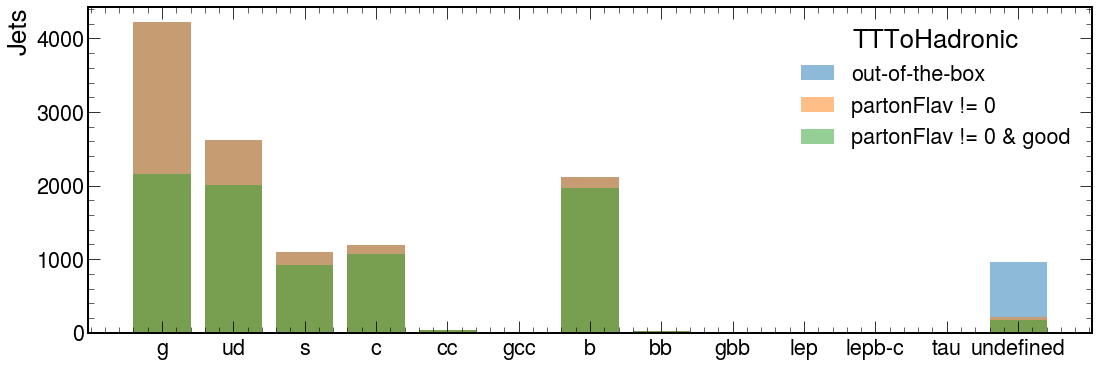

In [63]:
f = plt.figure(figsize=(18,6))
plt.bar(labels, height, alpha=0.5, label='out-of-the-box')
plt.bar(labels, height_noPU, alpha=0.5, label='partonFlav != 0')
plt.bar(labels, height_noPU_andGood, alpha=0.5, label='partonFlav != 0 & good')
#plt.bar(labels, heightDY_Good, alpha=0.5)
plt.ylabel('Jets')
plt.legend(title='TTToHadronic')

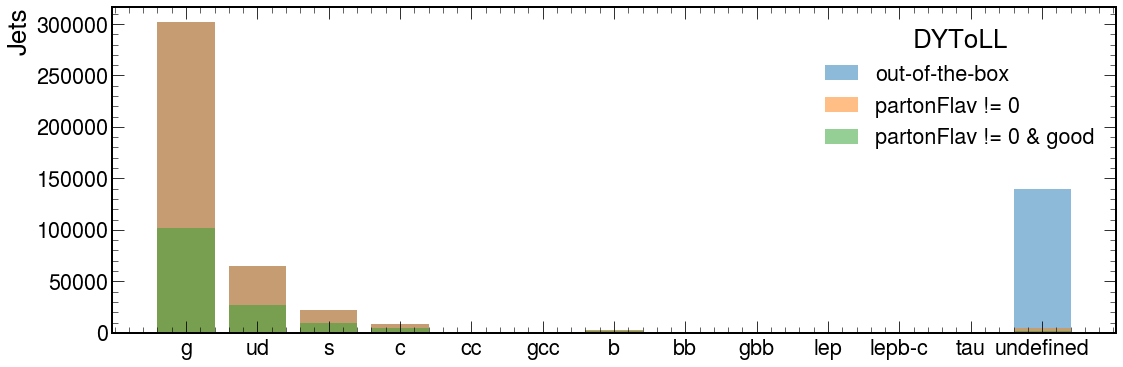

In [64]:
f = plt.figure(figsize=(18,6))
plt.bar(labels, heightDY, alpha=0.5, label='out-of-the-box')
plt.bar(labels, heightDY_noPU, alpha=0.5, label='partonFlav != 0')
plt.bar(labels, heightDY_noPU_andGood, alpha=0.5, label='partonFlav != 0 & good')
#plt.bar(labels, heightDY_Good, alpha=0.5)
plt.ylabel('Jets')
plt.legend(title='DYToLL')

In [61]:
import vector
vector.register_awkward()

In [172]:
pathStockMineDY = "~/private/pfnano_dev/CMSSW_10_6_20/src/PhysicsTools/PFNano/test/nano_mc2017_DYwithPULabel.root"

In [173]:
DYfile = uproot.open(pathStockMineDY)

In [174]:
pathStockMineTT = "~/private/pfnano_dev/CMSSW_10_6_20/src/PhysicsTools/PFNano/test/nano_mc2017_TTwithPULabel.root"

In [175]:
TTfile = uproot.open(pathStockMineTT)

In [176]:
labels = ['g', 'ud', 's', 'c', 'cc', 'gcc', 'b', 'bb', 'gbb', 'lepb', 'lepb-c', 'tau', 'PU', 'undefined']

In [220]:
x_axis = np.arange(len(labels))

In [177]:
from coffea.nanoevents import NanoEventsFactory, PFNanoAODSchema

In [269]:
def get_relevant_info_and_histo(file, path=pathStockMineTT, title='TTToHadronic'):
    #  jet_flavs = ak.flatten(file['Events']['Jet_FlavSplit'].arrays().Jet_FlavSplit, axis=-1).to_numpy()
    #  jet_partonFlav = ak.flatten(file['Events']['Jet_partonFlavour'].arrays().Jet_partonFlavour, axis=-1).to_numpy()
    #  jet_hadronFlav = ak.flatten(file['Events']['Jet_hadronFlavour'].arrays().Jet_hadronFlavour, axis=-1).to_numpy()
    #  jet_pt = ak.flatten(file['Events']['Jet_pt'].arrays().Jet_pt, axis=-1).to_numpy()
    #  jet_eta = ak.flatten(file['Events']['Jet_eta'].arrays().Jet_eta, axis=-1).to_numpy()
    #  jet_jetId = ak.flatten(file['Events']['Jet_jetId'].arrays().Jet_jetId, axis=-1).to_numpy()
    #  jet_puId = ak.flatten(file['Events']['Jet_puId'].arrays().Jet_puId, axis=-1).to_numpy()
    #  jet_muEF = ak.flatten(file['Events']['Jet_muEF'].arrays().Jet_muEF, axis=-1).to_numpy()
    #  jet_neEmEF = ak.flatten(file['Events']['Jet_neEmEF'].arrays().Jet_neEmEF, axis=-1).to_numpy()
    #jet_lepFilter = ak.flatten(file['Events']['Jet_lepFilter'].arrays().Jet_puId, axis=-1).to_numpy()
    
    
    events = NanoEventsFactory.from_root(
        path,
        schemaclass=PFNanoAODSchema,
        metadata={"dataset": title.split(' ')[0]},
    ).events()
    
    #events = uproot.open(f"{path}:Events")
    #array = events.arrays(filter_name="/(Muon_|Jet_).*/", library="ak", how="zip")
    #events = events.arrays(filter_name="/(Muon_|Jet_).*/", library="ak", how="zip")
    
    iso_muon = events.Muon[
            (events.Muon.pt > 30)
            & (abs(events.Muon.eta) < 2.4)
            & (events.Muon.tightId > 0.5)
            & (events.Muon.pfRelIso04_all <= 0.15)
        ]

    #req_muon = ak.count(iso_muon.pt, axis=1) == 1
    print('Isolated muons in all events (total): ', ak.sum(ak.count(iso_muon.pt, axis=1)))
    #iso_muon = ak.pad_none(iso_muon, 1, axis=1)
    #iso_muon = iso_muon[:, 0]
    
    #muons = ak.zip({"px": events.Muon_Px, "py": events.Muon_Py, "pz": events.Muon_Pz, "E": events.Muon_E}, with_name="Momentum4D")
    # muons = ak.zip(
    #         {
    #             "pt": iso_muon.pt,
    #             "eta": iso_muon.eta,
    #             "phi": iso_muon.phi,
    #             "mass": iso_muon.mass,
    #         },
    #         with_name="PtEtaPhiMLorentzVector",
    #     )
    #(ak.all(array.Jet.metric_table(iso_muon) > 0.5, axis=2))
    #        & ((events.Jet.muEF + events.Jet.neEmEF) < 0.7)
    #jets = ak.zip({"px": events.Jet_Px, "py": events.Jet_Py, "pz": events.Jet_Pz, "E": events.Jet_E}, with_name="Momentum4D")
    # jets = ak.zip(
    #         {
    #             "pt": events.Jet.pt,
    #             "eta": events.Jet.eta,
    #             "phi": events.Jet.phi,
    #             "mass": events.Jet.mass,
    #         },
    #         with_name="PtEtaPhiMLorentzVector",
    #     )
    # ms, js = ak.unzip(ak.cartesian((muons, jets)))
    
    #  event_jet = events.Jet[
    #          (events.Jet.pt > 20)
    #          & (abs(events.Jet.eta) < 2.5)
    #          & (((events.Jet.puId >= 1) & (events.Jet.pt < 50)) | (events.Jet.pt >= 50))
    #          & (events.Jet.jetId >= 5)
    #          & (ak.all(events.Jet.metric_table(iso_muon) > 0.5, axis=2))
    #          & ((events.Jet.muEF + events.Jet.neEmEF) < 0.7)
    #      ]
    print('Events (total): ', len(events.Jet))
    partonFlav_mask = (events.Jet.partonFlavour != 0)
    noPU_mask = ~((events.Jet.partonFlavour == 0) & (events.Jet.hadronFlavour == 0) )
    
    basicGoodJet_mask = ((events.Jet.pt > 20) \
                      & (abs(events.Jet.eta) < 2.5) \
                      & ((events.Jet.puId >= 1) | (events.Jet.pt > 50)) \
                      & (events.Jet.jetId >= 5) )
    
    cleanLepton_mask = ( (ak.all(events.Jet.metric_table(iso_muon) > 0.5, axis=2))\
                     & ((events.Jet.muEF + events.Jet.neEmEF) < 0.7) )
    print(cleanLepton_mask.type)
    #print(events.Jet.metric_table(iso_muon))
    #print(cleanLepton_mask)
    print('Jets that were not yet cleaned for muons (total): ', ak.sum(cleanLepton_mask != 1))
    original_jets = events.Jet
    print('Jets (total): ', len(ak.flatten(original_jets.pt)))
    jets_partonFlavNot0 = events.Jet[partonFlav_mask]
    jets_noPU = events.Jet[noPU_mask]
    jets_noPU_andGood = events.Jet[noPU_mask & basicGoodJet_mask]   
    jets_noPU_andGood_andLepClean = events.Jet[noPU_mask & basicGoodJet_mask & cleanLepton_mask]                      
                         
                         
    flav_original = ak.flatten(original_jets.FlavSplit, axis=-1).to_numpy()
    print('Jets (total): ', len(ak.flatten(original_jets.FlavSplit, axis=-1)))
    flav_partonFlav = ak.flatten(jets_partonFlavNot0.FlavSplit, axis=-1).to_numpy()
    print('Jets partonFlav != 0 (total): ', len(ak.flatten(jets_partonFlavNot0.FlavSplit, axis=-1)))
    flav_noPU = ak.flatten(jets_noPU.FlavSplit, axis=-1).to_numpy()
    print('Jets partonFlav != 0 (total): ', len(ak.flatten(jets_noPU.FlavSplit, axis=-1)))
    flav_noPU_andGood = ak.flatten(jets_noPU_andGood.FlavSplit, axis=-1).to_numpy()
    print('Jets partonFlav != 0 & good (total): ', len(ak.flatten(jets_noPU_andGood.FlavSplit, axis=-1)))
    flav_noPU_andGood_andLepClean = ak.flatten(jets_noPU_andGood_andLepClean.FlavSplit, axis=-1).to_numpy()
    print('Jets partonFlav != 0 & good & lepClean (total): ', len(ak.flatten(jets_noPU_andGood_andLepClean.FlavSplit, axis=-1)))
    #jets = file['Events']
    #(ak.all(events.Jet.metric_table(iso_muon) > 0.5, axis=2))
    #        & ((events.Jet.muEF + events.Jet.neEmEF) < 0.7)
    
    #height, xvars = np.histogram(jet_flavs, bins=(0,1,2,400,410,411,500,510,511,520,521,600,999,1000,1001))
    height, xvars = np.histogram(flav_original, bins=(0,1,2,400,410,411,500,510,511,520,521,600,999,1000,1001))
    #print(np.unique(jet_flavs))
    #print(height)
    height_partonFlav, xvars_partonFlav = np.histogram(flav_partonFlav, bins=(0,1,2,400,410,411,500,510,511,520,521,600,999,1000,1001))
    height_noPU, xvars_noPU = np.histogram(flav_noPU, bins=(0,1,2,400,410,411,500,510,511,520,521,600,999,1000,1001))
    height_noPU_andGood, xvars_noPU_andGood = np.histogram(flav_noPU_andGood, bins=(0,1,2,400,410,411,500,510,511,520,521,600,999,1000,1001))
    height_noPU_andGoodandLep, xvars_noPU_andGoodandLep = np.histogram(flav_noPU_andGood_andLepClean, bins=(0,1,2,400,410,411,500,510,511,520,521,600,999,1000,1001))
    
    #  height_noPU, xvars_noPU = np.histogram(jet_flavs[(jet_partonFlav != 0)], 
    #                                         bins=(0,1,2,400,410,411,500,510,511,520,521,600,999,1000,1001))
    #  height_noPU_andGood, xvars_noPU_andGood = np.histogram(jet_flavs[(jet_partonFlav != 0) & (((jet_puId >= 1) | (jet_pt > 50)) & (jet_jetId >= 5) & (abs(jet_eta) < 2.5))],
    #                                                         bins=(0,1,2,400,410,411,500,510,511,520,521,600,999,1000,1001))
    #  height_noPU_andGoodandEF, xvars_noPU_andGoodandEF = np.histogram(jet_flavs[((jet_partonFlav != 0) & (((jet_puId >= 1) | (jet_pt > 50)) & (jet_jetId >= 5) & (abs(jet_eta) < 2.5)) ) & (jet_muEF + jet_neEmEF < 0.7)],
    #                                                                   bins=(0,1,2,400,410,411,500,510,511,520,521,600,999,1000,1001))
    #  
    #  height_Good, xvars_Good = np.histogram(jet_flavs[(((jet_puId >= 1) | (jet_pt > 50)) & (jet_jetId >= 5) & (abs(jet_eta) < 2.5))],
    #                                         bins=(0,1,2,400,410,411,500,510,511,520,521,600,999,1000,1001))
    
    
    f = plt.figure(figsize=(22,10))
    plt.bar(x_axis -0.3, height, alpha=0.4, label='out-of-the-box', width=0.15)
    plt.bar(x_axis -0.15, height_partonFlav, alpha=0.4, label='partonFlav != 0', width=0.15)
    plt.bar(x_axis -0.0, height_noPU, alpha=0.4, label='!(partonFlav == 0 & hadronFlav == 0)', width=0.15)
    plt.bar(x_axis +0.15, height_noPU_andGood, alpha=0.4, label='!(partonFlav == 0 & hadronFlav == 0) & good', width=0.15)
    plt.bar(x_axis +0.3, height_noPU_andGoodandLep, alpha=0.4, label='!(partonFlav == 0 & hadronFlav == 0) & good & isoMuon cleaned', width=0.15)
    #plt.bar(labels, heightDY_Good, alpha=0.5)
    plt.ylabel('Jets')
    plt.xticks(x_axis, labels)
    plt.legend(title=title)

/afs/desy.de/user/a/anstein/miniconda3/envs/coffea-env/lib/python3.7/site-packages/coffea/nanoevents/mapping/uproot.py:76: UserWarning: Found duplicate branch FatJet_btagDDBvLV2 in <TTree 'Events' (2439 branches) at 0x7fd7bac065d0>, taking first instance
  f"Found duplicate branch {key} in {tree}, taking first instance"
/afs/desy.de/user/a/anstein/miniconda3/envs/coffea-env/lib/python3.7/site-packages/coffea/nanoevents/mapping/uproot.py:76: UserWarning: Found duplicate branch FatJet_btagDDCvBV2 in <TTree 'Events' (2439 branches) at 0x7fd7bac065d0>, taking first instance
  f"Found duplicate branch {key} in {tree}, taking first instance"
/afs/desy.de/user/a/anstein/miniconda3/envs/coffea-env/lib/python3.7/site-packages/coffea/nanoevents/mapping/uproot.py:76: UserWarning: Found duplicate branch FatJet_btagDDCvLV2 in <TTree 'Events' (2439 branches) at 0x7fd7bac065d0>, taking first instance
  f"Found duplicate branch {key} in {tree}, taking first instance"
/afs/desy.de/user/a/anstein/minico

Isolated muons in all events (total):  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Events (total):  5000
5000 * var * bool
Jets that were not yet cleaned for muons (total):  818
Jets (total):  53485
Jets (total):  53485
Jets partonFlav != 0 (total):  50261
Jets partonFlav != 0 (total):  50274
Jets partonFlav != 0 & good (total):  30471
Jets partonFlav != 0 & good & lepClean (total):  29899


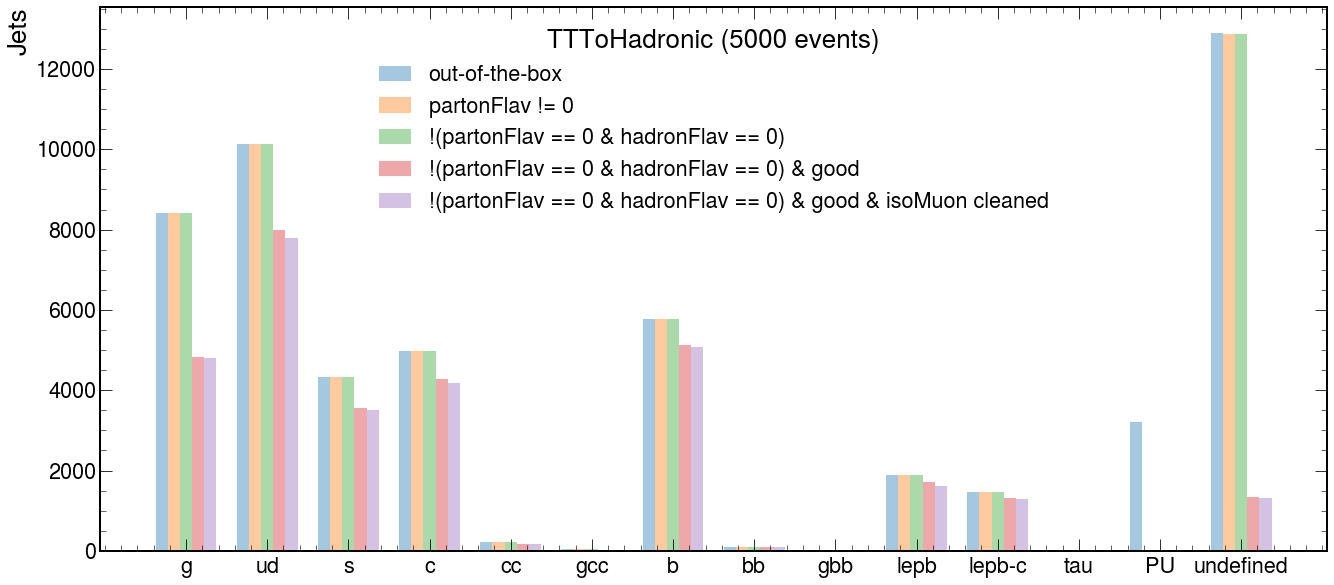

In [270]:
get_relevant_info_and_histo(TTfile, pathStockMineTT, 'TTToHadronic (5000 events)')

/afs/desy.de/user/a/anstein/miniconda3/envs/coffea-env/lib/python3.7/site-packages/coffea/nanoevents/mapping/uproot.py:76: UserWarning: Found duplicate branch FatJet_btagDDBvLV2 in <TTree 'Events' (2439 branches) at 0x7fd7804f7990>, taking first instance
  f"Found duplicate branch {key} in {tree}, taking first instance"
/afs/desy.de/user/a/anstein/miniconda3/envs/coffea-env/lib/python3.7/site-packages/coffea/nanoevents/mapping/uproot.py:76: UserWarning: Found duplicate branch FatJet_btagDDCvBV2 in <TTree 'Events' (2439 branches) at 0x7fd7804f7990>, taking first instance
  f"Found duplicate branch {key} in {tree}, taking first instance"
/afs/desy.de/user/a/anstein/miniconda3/envs/coffea-env/lib/python3.7/site-packages/coffea/nanoevents/mapping/uproot.py:76: UserWarning: Found duplicate branch FatJet_btagDDCvLV2 in <TTree 'Events' (2439 branches) at 0x7fd7804f7990>, taking first instance
  f"Found duplicate branch {key} in {tree}, taking first instance"
/afs/desy.de/user/a/anstein/minico

Isolated muons in all events (total):  1368
Events (total):  5000
5000 * var * bool
Jets that were not yet cleaned for muons (total):  2838
Jets (total):  29026
Jets (total):  29026
Jets partonFlav != 0 (total):  21731
Jets partonFlav != 0 (total):  21750
Jets partonFlav != 0 & good (total):  4385
Jets partonFlav != 0 & good & lepClean (total):  3877


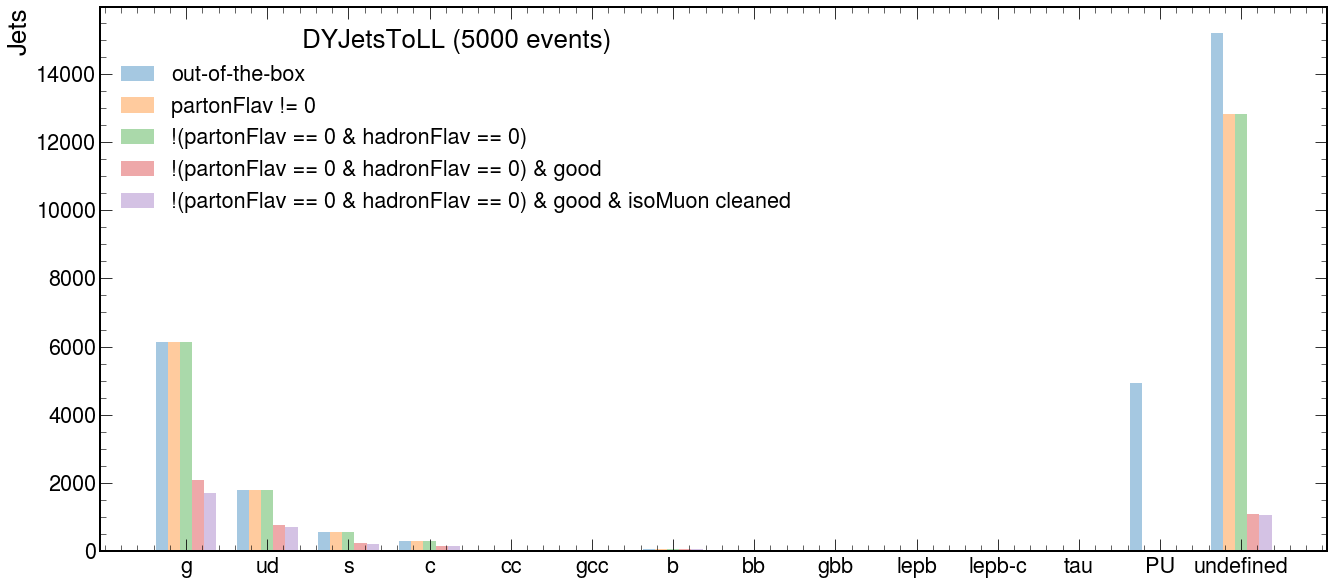

In [258]:
get_relevant_info_and_histo(DYfile, pathStockMineDY, 'DYJetsToLL (5000 events)')

In [34]:
np.sum(jet_flavs[jet_flavs==1000])/1000

139850.0

In [122]:
if False <= 0:
    print('yep')

yep


In [126]:
for data in fileStock2['Events'].iterate(["Muon_mass","Muon_pt","Muon_eta","Muon_tightId","Muon_pfRelIso04_all"], step_size=fileStock2['Events'].num_entries, library='pd'):
    break

In [127]:
data[:19]

Muon_mass    Muon_pt  Muon_eta  Muon_tightId  \
entry subentry                                                 
0     0          0.105713   6.894824  1.462891          True   
1     0          0.105713   5.258268  1.118652          True   
3     0          0.105713   4.776484 -0.321838          True   
8     0          0.105713  18.625374  1.285889          True   
12    0          0.105713   5.772525  2.180176         False   
      1          0.105713   3.461341 -1.438965         False   
14    0          0.105713   7.847552 -0.616699          True   
15    0          0.105713  40.944870 -1.272705          True   
16    0          0.105713   4.679722  0.694580         False   
      1          0.105713   4.336269  0.583496         False   
17    0          0.105713  29.470564 -0.274536          True   
20    0          0.105713  34.513947  0.615967          True   
      1          0.105652   4.315166  2.064941         False   
21    0          0.105652   3.288666 -1.424316         False   
26    0          0.105713  45.709427 -0.342590          True   
31    0          0.105713  18.130861  1.473145          True   
      1          0.105713   3.122571  1.416016          True   
32    0          0.105713  62.814137  0.171265          True   
      1          0.105713  16.541241  0.713867          True   

                Muon_pfRelIso04_all  
entry subentry                       
0     0                    1.174873  
1     0                    5.618700  
3     0                   17.226768  
8     0                    0.055665  
12    0                    1.281596  
      1                   13.395839  
14    0                    3.325467  
15    0                    0.063264  
16    0                   11.868073  
      1                    6.067607  
17    0                    0.020844  
20    0                    0.084338  
      1                    5.350124  
21    0                    5.378492  
26    0                    0.000000  
31    0                    0.000000  
      1                    2.810790  
32    0                    0.003600  
      1                    2.071199

In [120]:
for dataE in fileStock2['Events'].iterate(["Electron_mass","Electron_eta","Electron_pt","Electron_mvaFall17V2Iso_WP80"], step_size=fileStock2['Events'].num_entries, library='pd'):
    break

In [121]:
dataE[:19]

Electron_mass  Electron_eta  Electron_pt  \
entry subentry                                             
0     0             -0.034546      0.795288    71.864670   
      1              0.000376     -0.457886     8.973927   
1     0              0.007744      0.393982    26.001202   
      1              0.005825      0.288574    26.221628   
3     0             -0.000158     -0.844849    42.065136   
      1             -0.002628      0.518433    25.802813   
4     0             -0.014015     -1.248047    34.197655   
6     0              0.011269     -2.043945    25.214291   
      1             -0.004044      0.995361    14.241823   
7     0             -0.017731     -1.057373    41.963039   
      1             -0.027008     -1.393066    33.614403   
8     0             -0.001233      0.102570     5.617739   
9     0              0.010223     -1.303223    32.291939   
12    0             -0.024719     -2.326660    28.363522   
13    0              0.000618      0.614868     5.997658   
14    0              0.004822     -0.639282    16.008305   
15    0             -0.005547     -0.161774    44.297127   
18    0              0.034363     -1.357422    76.505386   
      1              0.002523      0.335693     7.709888   

                Electron_mvaFall17V2Iso_WP80  
entry subentry                                
0     0                                False  
      1                                False  
1     0                                False  
      1                                 True  
3     0                                False  
      1                                 True  
4     0                                False  
6     0                                False  
      1                                False  
7     0                                False  
      1                                 True  
8     0                                False  
9     0                                 True  
12    0                                False  
13    0                                False  
14    0                                False  
15    0                                False  
18    0                                 True  
      1                                False

In [108]:
for dataJet in fileStock2['Events'].iterate("Jet_pt", step_size=fileStock2['Events'].num_entries, library='pd'):
    break

In [110]:
dataJet

Jet_pt
entry subentry           
0     0         82.187500
      1         70.125000
      2         49.375000
      3         33.187500
      4         32.625000
...                   ...
11691 3         39.562500
      4         37.281250
      5         34.312500
      6         22.453125
      7         15.218750

[102546 rows x 1 columns]

In [109]:
dataJet[:19]

Jet_pt
entry subentry            
0     0          82.187500
      1          70.125000
      2          49.375000
      3          33.187500
      4          32.625000
      5          31.953125
      6          30.046875
      7          15.554688
1     0         148.000000
      1         114.562500
      2          42.468750
      3          30.546875
      4          28.203125
      5          23.171875
      6          17.234375
      7          16.125000
      8          15.664062
      9          15.445312
2     0          69.750000

In [95]:
for dataN in filePostProc['Events'].iterate("Muon_mass", step_size=filePostProc['Events'].num_entries, library='pd'):
    break

In [101]:
dataN[:19]

Muon_mass
entry subentry           
0     0          0.105713
      1          0.105713
1     0          0.105713
      1          0.105713
      2          0.105713
3     0          0.105713
4     0          0.105713
      1          0.105713
5     0          0.105713
6     0          0.105713
      1          0.105652
7     0          0.105713
      1          0.105713
8     0          0.105713
9     0          0.105713
11    0          0.105713
13    0          0.105713
      1          0.105713
14    0          0.105713

In [97]:
for dataNE in filePostProc['Events'].iterate("Electron_mass", step_size=filePostProc['Events'].num_entries, library='pd'):
    break

In [103]:
dataNE[:19]

Electron_mass
entry subentry               
0     0              0.006355
      1             -0.009399
      2             -0.003695
2     0             -0.012894
3     0              0.016617
      1              0.005978
5     0              0.005600
      1              0.003702
7     0              0.004189
      1              0.004261
8     0             -0.003435
10    0             -0.051727
11    0              0.002409
12    0              0.004715
14    0              0.019562
16    0              0.009598
17    0             -0.003864
19    0              0.009140
21    0              0.017822

In [99]:
for dataJetN in filePostProc['Events'].iterate("Jet_pt", step_size=filePostProc['Events'].num_entries, library='pd'):
    break

In [100]:
dataJetN[:19]

Jet_pt
entry subentry            
0     0         101.250000
      1          78.000000
      2          76.625000
      3          56.812500
      4          24.734375
      5          23.218750
      6          22.968750
      7          21.875000
      8          19.843750
1     0         197.250000
      1         190.125000
      2          94.562500
      3          90.187500
      4          62.156250
      5          17.468750
      6          16.734375
      7          16.203125
2     0          84.062500
      1          83.437500

In [111]:
dataJetN

Jet_pt
entry  subentry            
0      0         101.250000
       1          78.000000
       2          76.625000
       3          56.812500
       4          24.734375
...                     ...
129341 2          59.531250
       3          41.062500
       4          32.343750
       5          17.562500
       6          15.414062

[1146801 rows x 1 columns]

In [ ]:
cleandataset(uproot.open("root://grid-cms-xrootd.physik.rwth-aachen.de:1094//store/user/anovak/PFNano/106X_v2_17/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/RunIIFall17PFNanoAODv2-PU2017_12Apr2018_new_pmx_94X_mc2017_realistic_v14-v1PFNanoV2/210101_174326/0001/nano_mc2017_1-1156.root"), defaults)

In [1]:
pathStockData = "root://grid-cms-xrootd.physik.rwth-aachen.de:1094//store/user/anovak/PFNano/106X_v2_17rsb2/SingleMuon/Run2017C-31Mar2018-v1_PFNanoAODv2/210114_202356/0000/nano_data2017_98.root"

In [4]:
fileStockData = uproot.open(pathStockData)

In [11]:
[key for key in fileStockData['Events'].keys() if "Jet_b" in key]

['FatJet_btagCMVA',
 'FatJet_btagCSVV2',
 'FatJet_btagDDBvL',
 'FatJet_btagDDBvLV2',
 'FatJet_btagDDBvL_noMD',
 'FatJet_btagDDCvB',
 'FatJet_btagDDCvBV2',
 'FatJet_btagDDCvB_noMD',
 'FatJet_btagDDCvL',
 'FatJet_btagDDCvLV2',
 'FatJet_btagDDCvL_noMD',
 'FatJet_btagDeepB',
 'FatJet_btagHbb',
 'Jet_btagCMVA',
 'Jet_btagCSVV2',
 'Jet_btagDeepB',
 'Jet_btagDeepC',
 'Jet_btagDeepCvB',
 'Jet_btagDeepCvL',
 'Jet_btagDeepFlavB',
 'Jet_btagDeepFlavC',
 'Jet_btagDeepFlavCvB',
 'Jet_btagDeepFlavCvL',
 'Jet_btagDeepFlavQG',
 'Jet_bRegCorr',
 'Jet_bRegRes',
 'SubJet_btagCMVA',
 'SubJet_btagCSVV2',
 'SubJet_btagDeepB',
 'FatJet_btagDDBvLV2',
 'FatJet_btagDDCvBV2',
 'FatJet_btagDDCvLV2',
 'FatJet_btagDeepB_b',
 'FatJet_btagDeepB_bb',
 'FatJet_btagDeepL',
 'Jet_btagDeepB_b',
 'Jet_btagDeepB_bb',
 'Jet_btagDeepL',
 'SubJet_btagDeepB_b',
 'SubJet_btagDeepB_bb',
 'SubJet_btagDeepC',
 'SubJet_btagDeepL']

In [1]:
btagPFNanoPath = "root://grid-cms-xrootd.physik.rwth-aachen.de:1094//store/user/anovak/PFNano/106X_v2_17rsb2/BTagMu/Run2017D-31Mar2018-v1_PFNanoAOD/210210_201720/0000/nano_data2017_7.root"

In [4]:
filebtagPFNanoPath = uproot.open(btagPFNanoPath)

In [6]:
[key for key in filebtagPFNanoPath['Events'].keys() if "Jet_" in key]

['CorrT1METJet_area',
 'CorrT1METJet_eta',
 'CorrT1METJet_muonSubtrFactor',
 'CorrT1METJet_phi',
 'CorrT1METJet_rawPt',
 'FatJet_area',
 'FatJet_btagCMVA',
 'FatJet_btagCSVV2',
 'FatJet_btagDDBvL',
 'FatJet_btagDDBvLV2',
 'FatJet_btagDDBvL_noMD',
 'FatJet_btagDDCvB',
 'FatJet_btagDDCvBV2',
 'FatJet_btagDDCvB_noMD',
 'FatJet_btagDDCvL',
 'FatJet_btagDDCvLV2',
 'FatJet_btagDDCvL_noMD',
 'FatJet_btagDeepB',
 'FatJet_btagHbb',
 'FatJet_deepTagMD_H4qvsQCD',
 'FatJet_deepTagMD_HbbvsQCD',
 'FatJet_deepTagMD_TvsQCD',
 'FatJet_deepTagMD_WvsQCD',
 'FatJet_deepTagMD_ZHbbvsQCD',
 'FatJet_deepTagMD_ZHccvsQCD',
 'FatJet_deepTagMD_ZbbvsQCD',
 'FatJet_deepTagMD_ZvsQCD',
 'FatJet_deepTagMD_bbvsLight',
 'FatJet_deepTagMD_ccvsLight',
 'FatJet_deepTag_H',
 'FatJet_deepTag_QCD',
 'FatJet_deepTag_QCDothers',
 'FatJet_deepTag_TvsQCD',
 'FatJet_deepTag_WvsQCD',
 'FatJet_deepTag_ZvsQCD',
 'FatJet_eta',
 'FatJet_mass',
 'FatJet_msoftdrop',
 'FatJet_n2b1',
 'FatJet_n3b1',
 'FatJet_particleNetMD_QCD',
 'FatJet_pa

In [24]:
tttohad = 'root://grid-cms-xrootd.physik.rwth-aachen.de:1094//store/user/anovak/PFNano/106X_v2_17/TTToHadronic_TuneCP5_13TeV-powheg-pythia8/RunIIFall17PFNanoAODv2-PU2017_12Apr2018_new_pmx_94X_mc2017_realistic_v14-v2PFNanoV2/210101_174238/0000/nano_mc2017_1.root'

In [25]:
tttohadfile = uproot.open(tttohad)

In [26]:
[key for key in tttohadfile['Events'].keys() if "PS" in key]

['nPSWeight', 'PSWeight']

In [29]:
tttohadfile['Events'].arrays()[b'PSWeight']

AttributeError: 'NoneType' object has no attribute 'chunks'

KeyboardInterrupt: 

In [4]:
tttosemilep = 'root://grid-cms-xrootd.physik.rwth-aachen.de:1094//store/user/anovak/PFNano/106X_v2_17/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/RunIIFall17PFNanoAODv2-PU2017_12Apr2018_new_pmx_94X_mc2017_realistic_v14-v1PFNanoV2/210101_174326/0001/nano_mc2017_1-1156.root'

In [5]:
tttosemilepfile = uproot.open(tttosemilep)

In [6]:
[key for key in tttosemilepfile['Events'].keys() if "PS" in key]

['nPSWeight', 'PSWeight']

In [22]:
tttosemilepfile['Events'].arrays()[b'PSWeight']

<Array [[0.996, 1.07, 0.968, ... 1.01, 1.22]] type='11692 * var * float32'>

In [10]:
[key for key in tttosemilepfile['Events'].keys() if "Muon_pt" in key]

['Muon_pt', 'Muon_ptErr']

In [11]:
datapath = 'root://grid-cms-xrootd.physik.rwth-aachen.de:1094//store/user/anovak/PFNano/106X_v2_17rsb3/SingleMuon/Run2017C-31Mar2018-v1_PFNanov2/210509_154629/0000/nano_data2017_15.root'

In [12]:
datafile = uproot.open(datapath)

In [13]:
[key for key in datafile['Events'].keys() if "PS" in key]

[]

In [22]:
tttosemilepfile['Events'].arrays()[b'PSWeight']

<Array [[0.996, 1.07, 0.968, ... 1.01, 1.22]] type='11692 * var * float32'>

In [14]:
[key for key in datafile['Events'].keys() if "Muon_pt" in key]

['Muon_pt', 'Muon_ptErr']

In [15]:
[key for key in datafile['Events'].keys() if "Muon_" in key]

['Muon_dxy',
 'Muon_dxyErr',
 'Muon_dxybs',
 'Muon_dz',
 'Muon_dzErr',
 'Muon_eta',
 'Muon_ip3d',
 'Muon_jetPtRelv2',
 'Muon_jetRelIso',
 'Muon_mass',
 'Muon_miniPFRelIso_all',
 'Muon_miniPFRelIso_chg',
 'Muon_pfRelIso03_all',
 'Muon_pfRelIso03_chg',
 'Muon_pfRelIso04_all',
 'Muon_phi',
 'Muon_pt',
 'Muon_ptErr',
 'Muon_segmentComp',
 'Muon_sip3d',
 'Muon_tkRelIso',
 'Muon_tunepRelPt',
 'Muon_mvaLowPt',
 'Muon_mvaTTH',
 'Muon_charge',
 'Muon_jetIdx',
 'Muon_nStations',
 'Muon_nTrackerLayers',
 'Muon_pdgId',
 'Muon_tightCharge',
 'Muon_fsrPhotonIdx',
 'Muon_highPtId',
 'Muon_highPurity',
 'Muon_inTimeMuon',
 'Muon_isGlobal',
 'Muon_isPFcand',
 'Muon_isTracker',
 'Muon_jetNDauCharged',
 'Muon_looseId',
 'Muon_mediumId',
 'Muon_mediumPromptId',
 'Muon_miniIsoId',
 'Muon_multiIsoId',
 'Muon_mvaId',
 'Muon_mvaLowPtId',
 'Muon_pfIsoId',
 'Muon_softId',
 'Muon_softMvaId',
 'Muon_tightId',
 'Muon_tkIsoId',
 'Muon_triggerIdLoose',
 'Muon_cleanmask',
 'HLT_Dimuon0_Upsilon_Muon_L1_TM0',
 'HLT_Dim

In [16]:
[key for key in datafile['Events'].keys() if "Electron_" in key]

['Electron_deltaEtaSC',
 'Electron_dr03EcalRecHitSumEt',
 'Electron_dr03HcalDepth1TowerSumEt',
 'Electron_dr03TkSumPt',
 'Electron_dr03TkSumPtHEEP',
 'Electron_dxy',
 'Electron_dxyErr',
 'Electron_dz',
 'Electron_dzErr',
 'Electron_eCorr',
 'Electron_eInvMinusPInv',
 'Electron_energyErr',
 'Electron_eta',
 'Electron_hoe',
 'Electron_ip3d',
 'Electron_jetPtRelv2',
 'Electron_jetRelIso',
 'Electron_mass',
 'Electron_miniPFRelIso_all',
 'Electron_miniPFRelIso_chg',
 'Electron_mvaFall17V1Iso',
 'Electron_mvaFall17V1noIso',
 'Electron_mvaFall17V2Iso',
 'Electron_mvaFall17V2noIso',
 'Electron_pfRelIso03_all',
 'Electron_pfRelIso03_chg',
 'Electron_phi',
 'Electron_pt',
 'Electron_r9',
 'Electron_scEtOverPt',
 'Electron_sieie',
 'Electron_sip3d',
 'Electron_mvaTTH',
 'Electron_charge',
 'Electron_cutBased',
 'Electron_cutBased_Fall17_V1',
 'Electron_jetIdx',
 'Electron_pdgId',
 'Electron_photonIdx',
 'Electron_tightCharge',
 'Electron_vidNestedWPBitmap',
 'Electron_vidNestedWPBitmapHEEP',
 'E

In [ ]:
print(torch.unique(targets))

In [72]:
mcpath = 'root://grid-cms-xrootd.physik.rwth-aachen.de:1094//store/user/anovak/PFNano/106X_v2_17rsb3/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIFall17PFNanov2-PU2017RECOSIMstep_12Apr2018_94X_mc2017_realistic_v14_ext1-v1/210509_154511/0000/nano_mc2017_26.root'

In [74]:
mcfile = uproot.open(mcpath)

In [75]:
[key for key in mcfile['Events'].keys() if "Jet_Deep" in key]

['Jet_DeepCSV_flightDistance2dSig',
 'Jet_DeepCSV_flightDistance2dVal',
 'Jet_DeepCSV_flightDistance3dSig',
 'Jet_DeepCSV_flightDistance3dVal',
 'Jet_DeepCSV_trackDecayLenVal_0',
 'Jet_DeepCSV_trackDecayLenVal_1',
 'Jet_DeepCSV_trackDecayLenVal_2',
 'Jet_DeepCSV_trackDecayLenVal_3',
 'Jet_DeepCSV_trackDecayLenVal_4',
 'Jet_DeepCSV_trackDecayLenVal_5',
 'Jet_DeepCSV_trackDeltaR_0',
 'Jet_DeepCSV_trackDeltaR_1',
 'Jet_DeepCSV_trackDeltaR_2',
 'Jet_DeepCSV_trackDeltaR_3',
 'Jet_DeepCSV_trackDeltaR_4',
 'Jet_DeepCSV_trackDeltaR_5',
 'Jet_DeepCSV_trackEtaRel_0',
 'Jet_DeepCSV_trackEtaRel_1',
 'Jet_DeepCSV_trackEtaRel_2',
 'Jet_DeepCSV_trackEtaRel_3',
 'Jet_DeepCSV_trackJetDistVal_0',
 'Jet_DeepCSV_trackJetDistVal_1',
 'Jet_DeepCSV_trackJetDistVal_2',
 'Jet_DeepCSV_trackJetDistVal_3',
 'Jet_DeepCSV_trackJetDistVal_4',
 'Jet_DeepCSV_trackJetDistVal_5',
 'Jet_DeepCSV_trackJetPt',
 'Jet_DeepCSV_trackPtRatio_0',
 'Jet_DeepCSV_trackPtRatio_1',
 'Jet_DeepCSV_trackPtRatio_2',
 'Jet_DeepCSV_trackPtR

In [76]:
len([key for key in mcfile['Events'].keys() if "Jet_Deep" in key])

65

In [ ]:
mcfile['Events'].arrays()[b'Jet_pt']

In [77]:
for dyvertcat in mcfile['Events'].iterate("Jet_DeepCSV_vertexCategory", step_size=mcfile['Events'].num_entries, library='pd'):
    break

In [78]:
dyvertcat

Jet_DeepCSV_vertexCategory
entry  subentry                            
0      0                                2.0
       1                             -999.0
       2                             -999.0
       3                                2.0
       4                                2.0
...                                     ...
291185 4                                2.0
       5                                2.0
       6                                2.0
       7                                2.0
       8                                2.0

[1403677 rows x 1 columns]

In [79]:
dyvertcat.describe()

,Jet_DeepCSV_vertexCategory
count,1.403677e+06
mean,-3.947047e+02
std,4.895552e+02
min,-9.990000e+02
25%,-9.990000e+02
50%,2.000000e+00
75%,2.000000e+00
max,2.000000e+00


In [80]:
dyvertcat.drop_duplicates()

Jet_DeepCSV_vertexCategory
entry subentry                            
0     0                                2.0
      1                             -999.0
24    3                                0.0
320   0                                1.0

array([[<AxesSubplot:title={'center':'Jet_DeepCSV_vertexCategory'}>]],
      dtype=object)

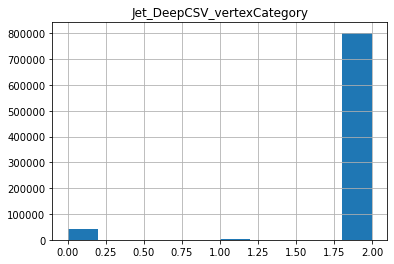

In [81]:
dyvertcat[dyvertcat > -1].hist()

In [82]:
ttmcpath = 'root://grid-cms-xrootd.physik.rwth-aachen.de:1094//store/user/anovak/PFNano/106X_v2_17/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/RunIIFall17PFNanoAODv2-PU2017_12Apr2018_new_pmx_94X_mc2017_realistic_v14-v1PFNanoV2/210101_174326/0001/nano_mc2017_1-1156.root'

In [58]:
ttmcfile = uproot.open(ttmcpath)

In [59]:
[key for key in ttmcfile['Events'].keys() if "Jet_Deep" in key]

['Jet_DeepCSV_flightDistance2dSig',
 'Jet_DeepCSV_flightDistance2dVal',
 'Jet_DeepCSV_flightDistance3dSig',
 'Jet_DeepCSV_flightDistance3dVal',
 'Jet_DeepCSV_trackDecayLenVal_0',
 'Jet_DeepCSV_trackDecayLenVal_1',
 'Jet_DeepCSV_trackDecayLenVal_2',
 'Jet_DeepCSV_trackDecayLenVal_3',
 'Jet_DeepCSV_trackDecayLenVal_4',
 'Jet_DeepCSV_trackDecayLenVal_5',
 'Jet_DeepCSV_trackDeltaR_0',
 'Jet_DeepCSV_trackDeltaR_1',
 'Jet_DeepCSV_trackDeltaR_2',
 'Jet_DeepCSV_trackDeltaR_3',
 'Jet_DeepCSV_trackDeltaR_4',
 'Jet_DeepCSV_trackDeltaR_5',
 'Jet_DeepCSV_trackEtaRel_0',
 'Jet_DeepCSV_trackEtaRel_1',
 'Jet_DeepCSV_trackEtaRel_2',
 'Jet_DeepCSV_trackEtaRel_3',
 'Jet_DeepCSV_trackJetDistVal_0',
 'Jet_DeepCSV_trackJetDistVal_1',
 'Jet_DeepCSV_trackJetDistVal_2',
 'Jet_DeepCSV_trackJetDistVal_3',
 'Jet_DeepCSV_trackJetDistVal_4',
 'Jet_DeepCSV_trackJetDistVal_5',
 'Jet_DeepCSV_trackJetPt',
 'Jet_DeepCSV_trackPtRatio_0',
 'Jet_DeepCSV_trackPtRatio_1',
 'Jet_DeepCSV_trackPtRatio_2',
 'Jet_DeepCSV_trackPtR

In [60]:
len([key for key in ttmcfile['Events'].keys() if "Jet_Deep" in key])

65

In [62]:
for vertcat in ttmcfile['Events'].iterate("Jet_DeepCSV_vertexCategory", step_size=ttmcfile['Events'].num_entries, library='pd'):
    break

In [63]:
vertcat

Jet_DeepCSV_vertexCategory
entry subentry                            
0     0                                2.0
      1                                2.0
      2                                0.0
      3                                2.0
      4                                0.0
...                                    ...
11691 3                                0.0
      4                                0.0
      5                                0.0
      6                                2.0
      7                             -999.0

[102546 rows x 1 columns]

In [64]:
vertcat.describe()

,Jet_DeepCSV_vertexCategory
count,102546.000000
mean,-205.602676
std,405.276733
min,-999.000000
25%,0.000000
50%,2.000000
75%,2.000000
max,2.000000


In [65]:
vertcat.drop_duplicates()

Jet_DeepCSV_vertexCategory
entry subentry                            
0     0                                2.0
      2                                0.0
      7                             -999.0
28    3                                1.0

array([[<AxesSubplot:title={'center':'Jet_DeepCSV_vertexCategory'}>]],
      dtype=object)

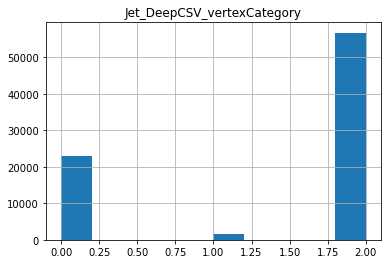

In [71]:
vertcat[vertcat > -1].hist()

In [83]:
datapath = 'root://grid-cms-xrootd.physik.rwth-aachen.de:1094//store/user/anovak/PFNano/106X_v2_17rsb3/SingleMuon/Run2017C-31Mar2018-v1_PFNanov2/210509_154629/0000/nano_data2017_15.root'

In [84]:
datafile = uproot.open(datapath)

In [85]:
for dvertcat in datafile['Events'].iterate("Jet_DeepCSV_vertexCategory", step_size=datafile['Events'].num_entries, library='pd'):
    break

In [86]:
dvertcat

Jet_DeepCSV_vertexCategory
entry subentry                            
0     0                                2.0
      1                             -999.0
      2                             -999.0
      3                                2.0
1     0                                2.0
...                                    ...
16680 1                             -999.0
      2                             -999.0
      3                             -999.0
      4                             -999.0
      5                                2.0

[87423 rows x 1 columns]

In [87]:
dvertcat.describe()

,Jet_DeepCSV_vertexCategory
count,87423.000000
mean,-293.691772
std,456.511230
min,-999.000000
25%,-999.000000
50%,2.000000
75%,2.000000
max,2.000000


In [88]:
dvertcat.drop_duplicates()

Jet_DeepCSV_vertexCategory
entry subentry                            
0     0                                2.0
      1                             -999.0
7     2                                0.0
99    1                                1.0

array([[<AxesSubplot:title={'center':'Jet_DeepCSV_vertexCategory'}>]],
      dtype=object)

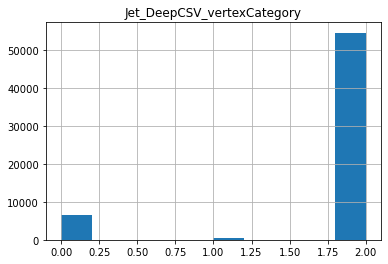

In [89]:
dvertcat[dvertcat > -1].hist()

In [92]:
feature_names = [k for k in datafile['Events'].keys() if  (('Jet_eta' == k) or ('Jet_pt' == k) or ('Jet_DeepCSV' in k))]

In [93]:
feature_names.index('Jet_DeepCSV_vertexCategory')

59

In [94]:
defaults[59]

-0.001